In [4]:
import cv2 as cv2

In [50]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import itertools
import equinox
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from csaps import csaps


import torch
from scipy.stats import norm, binom_test
import numpy as np
from math import ceil, sqrt
from statsmodels.stats.proportion import proportion_confint
from scipy import stats

import kornia

from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import StepLR
import time

from tqdm.auto import tqdm
import math

In [3]:
import imgaug

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!nvidia-smi

Fri May 12 10:20:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   37C    P0    60W / 300W |   3777MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [5]:
device= torch.device('cuda:4')

In [6]:
import os
import sys
sys.path.append('./..')
from tqdm import tqdm
import argparse
import torch
import torchvision
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


import datetime
# from tensorboardX import SummaryWriter
import wandb


from train_utils import AverageMeter, accuracy, init_logfile, log
from datasets0 import get_dataset, DATASETS, get_normalize_layer
from architectures import ARCHITECTURES, get_architecture

In [7]:
wandb.init(project="general_lipschitz", name = "test_run", tags = ["ResNet50", "BT"])

wandb: Currently logged in as: 68228322. Use `wandb login --relogin` to force relogin


In [8]:
from typing import *
def get_normalize_layer(dataset: str) -> torch.nn.Module:
    """Return the dataset's normalization layer"""
    if dataset == "imagenet":
        return NormalizeLayer(_IMAGENET_MEAN, _IMAGENET_STDDEV)
    elif dataset == "cifar10":
        return NormalizeLayer(_CIFAR10_MEAN, _CIFAR10_STDDEV)
    elif dataset == "mnist":
        return NormalizeLayer(_MNIST_MEAN, _MNIST_STDDEV)
    else:
        raise Exception("Unknown dataset")
        
_IMAGENET_MEAN = [0.485, 0.456, 0.406]
_IMAGENET_STDDEV = [0.229, 0.224, 0.225]


def _imagenet(split: str) -> Dataset:
    if not IMAGENET_LOC_ENV in os.environ:
        raise RuntimeError("environment variable for ImageNet directory not set")

    dir = os.environ[IMAGENET_LOC_ENV]
    if split == "train":
        subdir = os.path.join(dir, "train")
        transform = transforms.Compose([
            transforms.RandomSizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])
    elif split == "test":
        subdir = os.path.join(dir, "val")
        transform = transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])
    return datasets.ImageFolder(subdir, transform)



class NormalizeLayer(torch.nn.Module):
    """Standardize the channels of a batch of images by subtracting the dataset mean
      and dividing by the dataset standard deviation.

      In order to certify radii in original coordinates rather than standardized coordinates, we
      add the Gaussian noise _before_ standardizing, which is why we have standardization be the first
      layer of the classifier rather than as a part of preprocessing as is typical.
      """

    def __init__(self, means: List[float], sds: List[float]):
        """
        :param means: the channel means
        :param sds: the channel standard deviations
        """
        super(NormalizeLayer, self).__init__()
        self.means = torch.tensor(means).to(device)
        self.sds = torch.tensor(sds).to(device)
        self.means = torch.tensor(means).to(device)
        self.sds = torch.tensor(sds).to(device)
    def forward(self, input: torch.tensor):
        (batch_size, num_channels, height, width) = input.shape
        means = self.means.repeat((batch_size, height, width, 1)).permute(0, 3, 1, 2).contiguous()
        sds = self.sds.repeat((batch_size, height, width, 1)).permute(0, 3, 1, 2).contiguous()
        return (input - means) / sds

In [9]:
q ={'dataset':"imagenet"}


In [10]:
outdir = "/workspace/raid/data/ReportResults"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [192]:
# from semantic.transformers import gen_transformer, AbstractTransformer
def kl_div(input, targets, reduction='batchmean'):    return F.kl_div(F.log_softmax(input, dim=1), targets,
                    reduction=reduction)


def _cross_entropy(input, targets, reduction='mean'):
    targets_prob = F.softmax(targets, dim=1)
    xent = (-targets_prob * F.log_softmax(input, dim=1)).sum(1)
    if reduction == 'sum':
        return xent.sum()
    elif reduction == 'mean':
        return xent.mean()
    elif reduction == 'none':
        return xent
    else:
        raise NotImplementedError()


def _entropy(input, reduction='mean'):
    return _cross_entropy(input, input, reduction)




def _chunk_minibatch(batch, num_batches):
    X, y = batch
    batch_size = len(X) // num_batches
    for i in range(num_batches):
        yield X[i*batch_size : (i+1)*batch_size], y[i*batch_size : (i+1)*batch_size]



def train(loader: DataLoader, model: torch.nn.Module, criterion, optimizer, epoch: int,
          transformer, args, writer=None, name=None):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    losses_reg = AverageMeter()
    confidence = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()

    # switch to train mode
    model.train()

    for i, batch in enumerate(tqdm(loader)):
        # measure data loading time
        data_time.update(time.time() - end)

        mini_batches = _chunk_minibatch(batch, args['num_noise_vec'])
        for inputs, targets in mini_batches:
            targets = targets.to(device)
            batch_size = inputs.size(0)

            noised_inputs = [transformer(inputs.to(device)) for _ in range(args['num_noise_vec'])]

            # augment inputs with noise
            inputs_c = torch.cat(noised_inputs, dim=0)
            targets_c = targets.repeat(args['num_noise_vec'])

            logits = model(inputs_c)

            loss_xent = criterion(logits, targets_c)

            logits_chunk = torch.chunk(logits, args['num_noise_vec'], dim=0)
            softmax = [F.softmax(logit, dim=1) for logit in logits_chunk]
            avg_softmax = sum(softmax) /args['num_noise_vec']

            consistency = [kl_div(logit, avg_softmax, reduction='none').sum(1)
                           + _entropy(avg_softmax, reduction='none')
                           for logit in logits_chunk]
            consistency = sum(consistency) / args['num_noise_vec']
            consistency = consistency.mean()

            loss = loss_xent + args['lbd'] * consistency

            avg_confidence = -F.nll_loss(avg_softmax, targets)

            acc1, acc5 = accuracy(logits, targets_c, topk=(1, 5))
            losses.update(loss_xent.item(), batch_size)
            losses_reg.update(consistency.item(), batch_size)
            confidence.update(avg_confidence.item(), batch_size)
            top1.update(acc1.item(), batch_size)
            top5.update(acc5.item(), batch_size)

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args['print_freq'] == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.avg:.3f}\t'
                  'Data {data_time.avg:.3f}\t'
                  'Loss {loss.avg:.4f}\t'
                  'Acc@1 {top1.avg:.3f}\t'
                  'Acc@5 {top5.avg:.3f}'.format(
                epoch, i, len(loader), batch_time=batch_time,
                data_time=data_time, loss=losses, top1=top1, top5=top5))
            
            torch.save({
            'epoch': epoch + 1,
            'arch': args['arch'],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, os.path.join(outdir, args['transtype']+name+'_checkpoint.pth.tar'))
            wandb.log({
                f'epoch/{epoch}/loss/train': losses.avg,
                f'epoch/{epoch}/loss/consistency': losses_reg.avg,
                f'epoch/{epoch}/loss/avg_confidence': confidence.avg,
                f'epoch/{epoch}/batch_time': batch_time.avg,
                f'epoch/{epoch}/accuracy/train@1': top1.avg,
                f'epoch/{epoch}/accuracy/train@5': top5.avg
                
            })
        if i > 3:
            break

    
    wandb.log({
        "epoch": epoch,
        'loss/train': losses.avg,
        'loss/consistency': losses_reg.avg,
        'loss/avg_confidence': confidence.avg,
        'batch_time': batch_time.avg,
        'accuracy/train@1': top1.avg,
        'accuracy/train@5': top5.avg
        
    })

    return (losses.avg, top1.avg)


def test(loader, model, criterion, epoch, transformer, writer=None, print_freq=10):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()

    # switch to eval mode
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(loader)):
            # measure data loading time
            data_time.update(time.time() - end)

            inputs = inputs
            targets = targets.to(device)

            # augment inputs with noise
            inputs = transformer(inputs.to(device))

            # compute output
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(acc1.item(), inputs.size(0))
            top5.update(acc5.item(), inputs.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.avg:.3f}\t'
                      'Data {data_time.avg:.3f}\t'
                      'Loss {loss.avg:.4f}\t'
                      'Acc@1 {top1.avg:.3f}\t'
                      'Acc@5 {top5.avg:.3f}'.format(
                    i, len(loader), batch_time=batch_time, data_time=data_time,
                    loss=losses, top1=top1, top5=top5))
            if i > 3:
                break
        wandb.log({
            'loss/test': losses.avg,
            'accuracy/test@1': top1.avg,
            'accuracy/test@5': top5.avg
        
        })


        return (losses.avg, top1.avg)



In [74]:
# import torchvision.transforms.functional as F_t
# def norm_to_exp_torch(a):
#     return torch.log(2/torch.erfc(a/torch.sqrt(torch.tensor(2))))

# def Blur(tensor, kernel_size):
# #     kernel_size=
#     return F_t.gaussian_blur(tensor, kernel_size, sigma=None)


# def attack_tbbc_torch(x, b): #trans bright blur contrast

#     x = x.to(device)
#     translation = torch.tensor([[b[0].item(), b[1].item()]]).to(torch.float).to(device) #torch.tensor()
#     out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    
    
#     b2 = torch.tensor(b[2])
#     b2 = (2 * torch.floor(b2/2) + 1).int().item()
#     out = Blur(out, b2) 

#     out = out + b[3]

#     out = torch.tensor(b[4].item())* out
#     return out

# def phi_tbbc_torch_batch_and_noise(x, sigma_tr =40, sigma_b = 0.8, sigma_bl = torch.sqrt(torch.tensor(30)), sigma_c=0.8): #trans bright blur contrast
#     x = x.to(device)
#     c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
#     c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    
#     t = torch.tensor([1,0])
#     T = t.expand(len(x), *t.shape).clone()
#     T[:, 0] = c1.squeeze().clone()
#     T[:, 1] = c2.squeeze().clone()
    
#     out = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    

    
#     bl = sigma_bl * norm_to_exp_torch(torch.randn(len(x)))
#     bl = (2 * torch.floor (bl/2) + 1).to(torch.int)
    
#     blur_radii = [r.cpu().item() for r in bl]
#     for i in range(len(out)):
#         out[i] = Blur(out[i], blur_radii[i])

#     b = torch.randn(len(x)) * sigma_b
    
#     b = b[:,None,None,None].to(device)
#     out = out + b
    
    

#     c = torch.exp(torch.randn(len(x)) * sigma_c)[:, None, None, None]
#     out = c.to(device)*out

#     return out


In [75]:
def phi_bt_torch_batch_and_noise(x, sigma=0.8, tau=50):
#     x = x.expand(nsamples, *x.shape)
    x = x.to(device)
    
    q = torch.randn(len(x)) * sigma
    q = q[:,None,None,None]
    x = x + q.to(device)
    
    c1 = (torch.randn(len(x)) * tau).long()*1.0
    c2 = (torch.randn(len(x)) * tau).long()*1.0
    
    c1 = c1[:, None, None, None]
    c2 = c2[:, None, None, None]
    
#     nx, ny = c1, c2
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    out = kornia.geometry.transform.translate(x, T.float().to(device), padding_mode='reflection')
    return out


# def phi_bt_torch_batch(x, c):
# #     x = x.expand(nsamples, *x.shape)
#     x = x.to(device)
#     q = c[0][:,None,None,None]
#     x = x + q.to(device)
#     c1 = c[1][:, None, None, None]
#     c2 = c[2][:, None, None, None]
# #     nx, ny = c1  * np.sqrt(30.), c2  * np.sqrt(30.)
#     t = torch.tensor([1,0])
#     T = t.expand(nsamples, *t.shape).clone()
#     T[:, 0] = c1.squeeze().clone()
#     T[:, 1] = c2.squeeze().clone()
#     out = kornia.geometry.transform.translate(x, T.float().to(device), padding_mode='reflection')
#     return out
    

# def phi_bt_torch(x, c):
#     x = x + torch.tensor(c[0].item())
#     nx, ny = c[1]  * 30, c[2]*30
#     translation = torch.tensor([[nx.item(), ny.item()]])
#     out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    
#     return out

def attack_bt_torch(x, b):
    x = x.to(device) + torch.tensor(b[0].item())
    
    translation = torch.tensor([[b[1].item(), b[2].item()]]).to(device) #torch.tensor()

    out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
#     print('Shape after attack', out.shape)
    return out

In [15]:
epochs = 2
lr=1e-3
momentum=0.95
weight_decay=1e-4
lr_step_size =1
gamma=0.1
dataset='imagenet'
batch = 128
workers = 8

print_freq=2
arch='resnet50'
pin_memory = False
logfilename = os.path.join(outdir, 'log.txt')

In [16]:
train_dataset = get_dataset(dataset, 'train')
test_dataset = get_dataset(dataset, 'test')
pin_memory = False#(args.dataset == "imagenet")
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch,
                          num_workers = workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch,
                         num_workers = workers, pin_memory=pin_memory)




logfilename = os.path.join(outdir, 'log.txt')
init_logfile(logfilename, "epoch\ttime\tlr\ttrain loss\ttrain acc\ttestloss\ttest acc")
# writer = SummaryWriter(outdir)

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:919: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:312: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [17]:
Xs, ys = next(iter(train_loader))

In [18]:
def imshow(img):
    img = img # / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

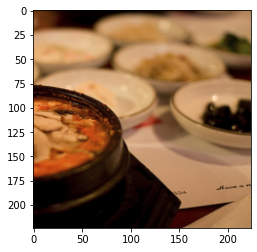

In [96]:
imshow(batch[0])

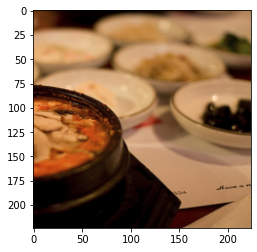

In [97]:
imshow(batch[1])

In [98]:
transformed_batch = phi_bt_torch_batch_and_noise(batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


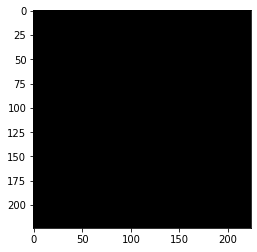

In [100]:
imshow(transformed_batch[0].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


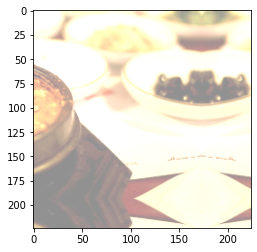

In [101]:
imshow(transformed_batch[1].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


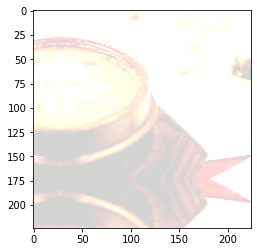

In [102]:
imshow(transformed_batch[2].cpu())

In [63]:
# checkpoint = torch.load('semantic-randomized-smoothing/models/imagenet/resnet50/brightness/pretrain_noise_0.4_0.4/checkpoint.pth.tar')
# model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
# normalize_layer = get_normalize_layer('imagenet').to(device)#.cuda()
# model = torch.nn.Sequential(normalize_layer, model)
# model.load_state_dict(checkpoint['state_dict'])
# # model.eval()
# model = model.to(device)

In [64]:
model = torchvision.models.resnet50(pretrained=True, progress=True)
normalize_layer = get_normalize_layer('imagenet')
model = torch.nn.Sequential(normalize_layer, model)

# model.eval()
model = model.to(device)

In [65]:
criterion = CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=gamma)

In [66]:
transformer = phi_bt_torch_batch_and_noise
epoch=0

In [67]:
# test(test_loader, model, criterion, epoch, transformer, writer=None, print_freq=10)

In [68]:
args = {'lr':lr, 'num_noise_vec':1, 'lbd':20, 'print_freq':10, 'arch':'resnet50', 'transtype':'gc', 'print_step':10 }

In [69]:
name = 'BrightTrans_08_408_2023'

In [76]:
for epoch in range(epochs):
    before = time.time()
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, transformer, args, writer, name=name)
    test_loss, test_acc = test(test_loader, model, criterion, epoch, transformer, writer, print_freq)
    after = time.time()

    scheduler.step(epoch)

    log(logfilename, "{}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}".format(
        epoch, str(datetime.timedelta(seconds=(after - before))),
        scheduler.get_lr()[0], train_loss, train_acc, test_loss, test_acc))
    
    print("{}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}".format(
        epoch, str(datetime.timedelta(seconds=(after - before))),
        scheduler.get_lr()[0], train_loss, train_acc, test_loss, test_acc))

    torch.save({
        'epoch': epoch + 1,
        'arch': arch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, os.path.join(outdir, name+'_checkpoint.pth.tar'))

  0%|                                                 | 0/10010 [00:00<?, ?it/s]

Epoch: [0][0/10010]	Time 3.513	Data 3.270	Loss 1.7517	Acc@1 57.031	Acc@5 79.688


  1%|▏                                          | 2/391 [00:02<07:55,  1.22s/it]

Test: [0/391]	Time 2.741	Data 2.598	Loss 2.1337	Acc@1 67.188	Acc@5 76.562


  1%|▍                                          | 4/391 [00:03<03:17,  1.95it/s]

Test: [2/391]	Time 1.023	Data 0.886	Loss 2.0955	Acc@1 60.417	Acc@5 78.125
Test: [4/391]	Time 0.675	Data 0.539	Loss 1.8706	Acc@1 65.156	Acc@5 81.406


  1%|▍                                          | 4/391 [00:04<07:01,  1.09s/it]
/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


0	0:0	0.001	1.91	58.8	1.87	65.2


  0%|                                                 | 0/10010 [00:00<?, ?it/s]

Epoch: [1][0/10010]	Time 3.205	Data 2.985	Loss 1.6576	Acc@1 65.625	Acc@5 78.906


  0%|                                           | 1/391 [00:02<16:35,  2.55s/it]

Test: [0/391]	Time 2.552	Data 2.399	Loss 1.1638	Acc@1 75.000	Acc@5 89.062


  1%|▍                                          | 4/391 [00:03<03:21,  1.92it/s]

Test: [2/391]	Time 1.018	Data 0.871	Loss 1.5409	Acc@1 65.625	Acc@5 86.458
Test: [4/391]	Time 0.678	Data 0.536	Loss 1.2433	Acc@1 71.719	Acc@5 89.219


  1%|▍                                          | 4/391 [00:04<06:54,  1.07s/it]


1	0:0	1e-05	1.9	59.5	1.24	71.7


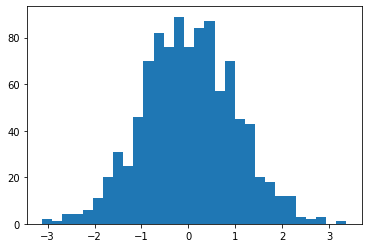

In [44]:
def norm_to_exp_torch(a):
    return torch.log(2/torch.erfc(a/torch.sqrt(torch.tensor(2))))
sig = 30
a = torch.randn(1000)#*sig

plt.hist(a.numpy(), bins=30)
plt.show()

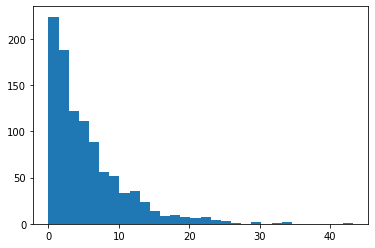

In [45]:
b = np.sqrt(sig)*norm_to_exp_torch(a).numpy()
plt.hist(b, bins=30)
plt.show()

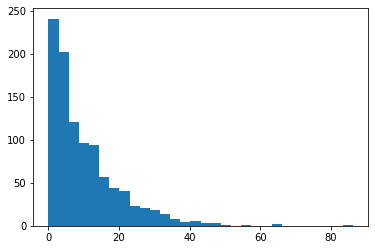

In [46]:
plt.hist(np.random.exponential(10, size=1000), bins=30)
plt.show()

In [79]:
import torchvision.transforms.functional as F_t

# Translation-Brightness-Blur-Contrast 

In [119]:
# import torchvision.transforms.functional as F_t
# def Blur(tensor, kernel_sizes):
#     kernel_sizes = list(kernel_sizes.numpy())
# #     kernel_size = int(kernel_size)
    
# #     if kernel_size%2==0:
# #         kernel_size +=1
#     return F_t.gaussian_blur(tensor, kernel_sizes, sigma=None)

In [129]:
# gauss = kornia.filters.GaussianBlur2d((11, 11), (10.5, 10.5))

# # blur the image
# x_blur: torch.tensor = gauss(batch.float())


In [158]:
input = 10 * torch.randn(1, 3, 224, 224)
cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [53]:
import cv2 

class Gaussian:
    # it adopts uniform distribution
    def __init__(self, sigma):
        self.sigma = sigma
        self.sigma2 = sigma ** 2.0

    def gen_param(self):
        r = random.uniform(0.0, self.sigma2)
        return r

    def proc(self, input, r2):
        if (abs(r2) < 1e-6):
            return input
        input = input.cpu().numpy()
        out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)
        if out.ndim == 2:
            out = np.expand_dims(out, 2)
        out = torch.from_numpy(out.transpose(2, 0, 1))
        return out #.cuda()
    
    def proc_new(self, input, r2):
        if (abs(r2) < 1e-6):
            return input
#         print(input.shape)
        input = input.cpu().numpy()
#         print(input.shape)
        out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)
        if out.ndim == 2:
            out = np.expand_dims(out, 2)
        out = torch.from_numpy(out.transpose(2, 0, 1))
        
        return out #.cuda()

    def batch_proc(self, inputs):
        outs = torch.zeros_like(inputs)
        for i in range(len(inputs)):
            outs[i] = self.proc(inputs[i], self.gen_param())
        return outs
    
class ExpGaussian(Gaussian):
    # it adopts exponential distribution
    # where the sigma is actually lambda in exponential distribution Exp(1/lambda)
    def __init__(self, sigma):
        super(ExpGaussian, self).__init__(sigma)
        self.sigma = sigma

    def gen_param(self):
#         r = - self.sigma * math.log(random.uniform(0.0, 1.0))
        r = np.random.exponential(scale=self.sigma)
        r = r#.to(device)
        return r
    
class RayGaussian(Gaussian):
    # it adopts exponential distribution
    # where the sigma is actually lambda in exponential distribution Exp(1/lambda)
    def __init__(self, sigma):
        super(RayGaussian, self).__init__(sigma)
        self.sigma = sigma

    def gen_param(self):
#         r = - self.sigma * math.log(random.uniform(0.0, 1.0))
        r = np.random.rayleigh(scale=self.sigma)
        return r

In [70]:
# kernel_size = tuple(map(int, np.ceil(3*np.array(s)) // 2 * 2 + 1))

In [177]:
batch = Xs[0].repeat(16, 1, 1, 1)

In [178]:
blurer = imgaug.augmenters.blur.GaussianBlur(sigma = [0, 3])
out = blurer.augment(images=batch.cpu().numpy().transpose(0,2,3,1))
out = torch.from_numpy(out.transpose(0,3,1,2)) #.to(device)

/tmp/ipykernel_21202/1996323277.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imshow(torch.tensor(out[0]))


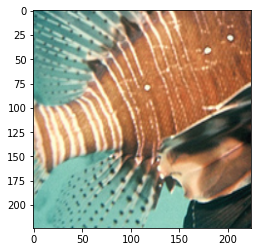

In [179]:
imshow(torch.tensor(out[0]))

/tmp/ipykernel_21202/648823952.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imshow(torch.tensor(out[2]))


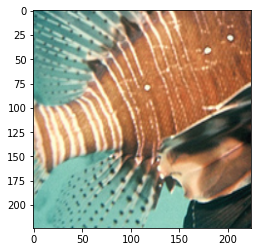

In [180]:
imshow(torch.tensor(out[2]))

In [181]:
s = [0, 3]

In [183]:
kernel_size = tuple(map(int, np.ceil(3*np.array(s)) // 2 * 2 + 1))
kernel_size

(1, 9)

In [184]:
blur = ExpGaussian(10)
out = blur.batch_proc(out)

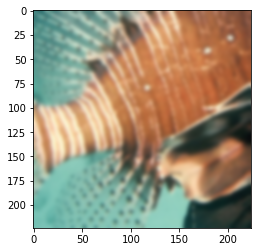

In [185]:
imshow(out[1])

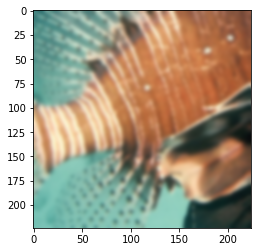

In [186]:
blurer = imgaug.augmenters.blur.GaussianBlur(sigma = [0, 10])
out = blurer.augment(images=out.cpu().numpy().transpose(0,2,3,1))
out = torch.from_numpy(out.transpose(0,3,1,2)).to(device)
imshow(out[1].cpu())

In [208]:
def phi_tbbc_torch_batch_and_noise(x, sigma_tr=40, sigma_b = 0.4, sigma_bl=10, sigma_c=0.4): #trans bright blur contrast
    x = x.to(device)
    c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    
    out = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    
    b = torch.randn(len(x)) * sigma_b
    b = b[:, None, None, None].to(device)
    out = out + b
    
    ###### v1
    blur = ExpGaussian(sigma_bl)
    out = blur.batch_proc(out)
    ##### v2 
#     blurer = imgaug.augmenters.blur.GaussianBlur(sigma = [0, sigma_bl])
#     out = blurer.augment(images=out.cpu().numpy().transpose(0,2,3,1))
#     out = torch.from_numpy(out.transpose(0,3,1,2)).to(device)

    c = torch.exp(torch.randn(len(x)) * sigma_c)[:, None, None, None].to(device)
    out = c * out

    return out



In [209]:
batch = Xs[0].repeat(16, 1, 1, 1)
transformed_batch = phi_tbbc_torch_batch_and_noise(batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


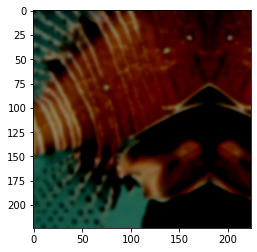

In [189]:
imshow(transformed_batch[6].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


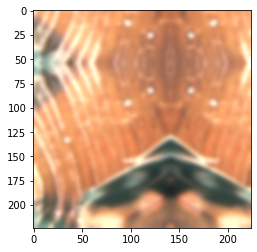

In [190]:
imshow(transformed_batch[2].cpu())

In [ ]:
epochs = 2
lr=1e-3
momentum=0.95
weight_decay=1e-4
lr_step_size =1
gamma=0.1
dataset='imagenet'
batch = 128
workers = 8

print_freq=2
arch='resnet50'
pin_memory = False
logfilename = os.path.join(outdir, 'log.txt')

In [ ]:
train_dataset = get_dataset(dataset, 'train')
test_dataset = get_dataset(dataset, 'test')
pin_memory = False
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch,
                          num_workers = workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch,
                         num_workers = workers, pin_memory=pin_memory)




logfilename = os.path.join(outdir, 'log.txt')
init_logfile(logfilename, "epoch\ttime\tlr\ttrain loss\ttrain acc\ttestloss\ttest acc")

In [ ]:
model = torchvision.models.resnet50(pretrained=True, progress=True)
normalize_layer = get_normalize_layer('imagenet')
model = torch.nn.Sequential(normalize_layer, model)
model = model.to(device)

In [ ]:
criterion = CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=gamma)

In [ ]:
transformer = phi_tbbc_torch_batch_and_noise

In [ ]:
args = {'lr':lr, 'num_noise_vec':1, 'lbd':20, 'print_freq':10, 'arch':'resnet50', 'transtype':'gc', 'print_step':10 }

In [ ]:
name = 'TransBrightBlurContrast_40_04_10_04'

In [201]:
wandb.init(project="general_lipschitz", name="TBBC", tags = ["ResNet50", "TBBC"])

In [210]:
for epoch in range(epochs):
    before = time.time()
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, transformer, args, writer=None, name=name)
    test_loss, test_acc = test(test_loader, model, criterion, epoch, transformer, writer=None, print_freq=print_freq)
    after = time.time()

    scheduler.step(epoch)

    log(logfilename, "{}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}".format(
        epoch, str(datetime.timedelta(seconds=(after - before))),
        scheduler.get_lr()[0], train_loss, train_acc, test_loss, test_acc))
    
    print("{}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}".format(
        epoch, str(datetime.timedelta(seconds=(after - before))),
        scheduler.get_lr()[0], train_loss, train_acc, test_loss, test_acc))

    torch.save({
        'epoch': epoch + 1,
        'arch': arch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, os.path.join(outdir, name+'_checkpoint.pth.tar'))

  0%|          | 0/10010 [00:01<?, ?it/s]

Epoch: [0][0/10010]	Time 9.983	Data 6.035	Loss 3.7632	Acc@1 31.250	Acc@5 49.219


  0%|          | 0/391 [00:06<?, ?it/s]

Test: [0/391]	Time 15.935	Data 11.248	Loss 3.5107	Acc@1 38.281	Acc@5 55.469
Test: [2/391]	Time 7.750	Data 3.823	Loss 3.7521	Acc@1 30.729	Acc@5 51.562


Process Process-92:
Process Process-95:
Process Process-107:
Process Process-91:
Process Process-108:
Process Process-106:
Process Process-90:
Process Process-111:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
Process Process-109:
Process Process-93:
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5ae7e64a60>
Traceback (most recent call last):
  File "/opt/co

KeyboardInterrupt: 

In [86]:
# def attack_tbbc_torch(x, b): #trans bright blur contrast

#     x = x.to(device)
#     translation = torch.tensor([[b[0].item(), b[1].item()]]).to(device) #torch.tensor()
#     out = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
#     out = out + b[2]

#     out = Blur(out, torch.tensor(b[3]).to(torch.int)) 
#     out = torch.tensor(b[4].item())* out
#     return out